# Place features

## Import dependencies

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from gedcom5.parser import GEDCOM5Parser
from gedcom5.tag import PLAC
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import Isomap
from sklearn.pipeline import make_pipeline

from common import walk

## Extract data

### Parse GEDCOM file

In [2]:
parser = GEDCOM5Parser()

with open("data/royal92.ged") as f:
    gedcom = parser.parse_string(f.read())

### Extract place names

In [3]:
places = [tag.value for tag in walk(gedcom) if isinstance(tag, PLAC)]
len(places)

1341

In [4]:
unique_places = sorted(set(places))
len(unique_places)

715

## Generate features from text similarity

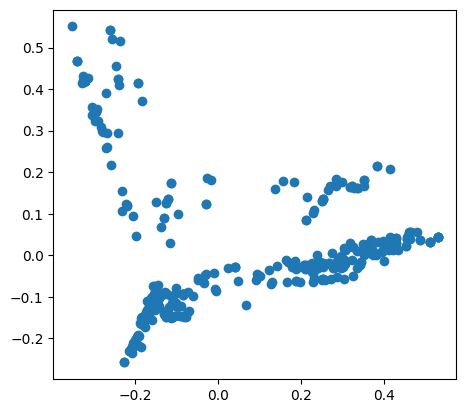

In [5]:
n_neighbors = len(places) - 1

pipeline = make_pipeline(
    CountVectorizer(),
    Isomap(n_neighbors=n_neighbors, metric="cosine"),
)
pipeline.fit(places)

features = pipeline.transform(unique_places)

fig, ax = plt.subplots()
ax.set_aspect(1)
ax.scatter(*features.T);

## Export features

In [6]:
df = pd.DataFrame(
    data=features,
    columns=["place_0", "place_1"],
    index=unique_places,
)
df.to_csv("data/place_features.csv")
df

,place_0,place_1
",,,England",0.509943,0.033108
",,,Ireland",-0.149154,-0.095430
",,,Russia",-0.161281,-0.101946
",,,U.S.A.",-0.147455,-0.092070
",,Brazil",-0.147899,-0.093747
...,...,...
"York Cottage,Sandringham,Norfolk,England",0.215296,-0.026891
York Minster,-0.143085,-0.096187
"York Place,,England",0.290973,-0.010439
Zuidschote,-0.147261,-0.092953


## Example clustering to explore groups

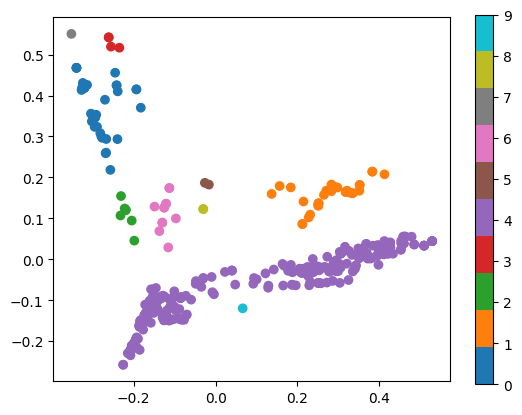

In [7]:
clustering = AgglomerativeClustering(n_clusters=10, linkage="single")
labels = clustering.fit_predict(features)

fig, ax = plt.subplots()
ax.set_aspect(1)
p = ax.scatter(*features.T, c=labels, cmap="tab10")
fig.colorbar(p);

In [8]:
df["label"] = labels
df.sort_values("label").groupby("label").head(1)

,place_0,place_1,label
"Auvergne,France",-0.320490,0.419968,0
"St. George Chap.,,Windsor,England",0.251799,0.136381,1
Rouen,-0.222318,0.123923,2
"St Denis,France",-0.261298,0.542452,3
",,,England",0.509943,0.033108,4
St. James Palac,-0.016385,0.182352,5
"Cathedral of the,Fortress of P&P,St. Petersburg,Russia",-0.115706,0.028683,6
France,-0.352585,0.550885,7
"Winter Palace,St. Petersburg,Russia",-0.030148,0.122574,8
"Winchester,Castle",0.066316,-0.120292,9
